# Superbolts

Exploring data from the World Wide Lightning Location Network (WWLLN).

Allen Downey
[MIT License](https://mit-license.org/)

In [1]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate

%load_ext nb_black

<IPython.core.display.Javascript object>

## One week of data

In [4]:
from glob import glob

filenames = glob("superbolts/AE201401*.loc")
dfs = [pd.read_csv(filename, header=None) for filename in filenames]

<IPython.core.display.Javascript object>

In [5]:
data = pd.concat(dfs)
data.shape

(4008245, 9)

<IPython.core.display.Javascript object>

Some records have no energy data.

In [6]:
no_energy_data = data[6] == 0
no_energy_data.mean()

0.11829965483646833

<IPython.core.display.Javascript object>

Replace 0 with NaN

In [7]:
data[6].replace(0, np.nan, inplace=True)
data[7].replace(0, np.nan, inplace=True)
data

,0,1,2,3,4,5,6,7,8
0,2014/1/1,00:00:00.102398,-24.3630,-62.5710,11.2,11,2558.58,228.02,6
1,2014/1/1,00:00:00.262488,-23.3254,-62.4138,5.9,6,9299.95,NaN,1
2,2014/1/1,00:00:00.351786,32.9734,48.2879,16.4,5,NaN,NaN,0
3,2014/1/1,00:00:00.180624,-24.6303,-62.8270,15.1,7,3719.68,819.25,4
4,2014/1/1,00:00:00.262459,-23.3717,-62.5272,12.2,5,5031.54,1523.71,5
...,...,...,...,...,...,...,...,...,...
566086,2014/1/6,23:59:48.961884,-19.9493,-67.5448,5.0,6,1271.09,NaN,1
566087,2014/1/6,23:59:48.628042,6.7217,-16.5172,9.6,5,5403.90,3780.22,5
566088,2014/1/6,23:59:48.323564,-19.7990,-67.6731,9.4,5,2581.11,677.25,5
566089,2014/1/6,23:59:48.193871,-19.7551,-67.8312,17.8,8,60623.83,14732.34,5


<IPython.core.display.Javascript object>

If the standard error exceeds 30% of the estimated value, the estimate is imprecise and should be discarded -- although it doesn't change the results much.

In [8]:
precise = data[7] < 0.3 * data[6]
precise.mean()

0.5768861434368409

<IPython.core.display.Javascript object>

Compute the log10 of the valid estimates.

In [9]:
# mags = np.log10(data[6].dropna())
mags = np.log10(data.loc[precise, 6].dropna())
mags.describe()

count    2.312301e+06
mean     3.565720e+00
std      5.896241e-01
min      6.095944e-01
25%      3.245856e+00
50%      3.594812e+00
75%      3.915426e+00
max      7.401412e+00
Name: 6, dtype: float64

<IPython.core.display.Javascript object>

Compute the tail distribution (fraction of values >= x for all x).

In [10]:
from empiricaldist import Pmf, Surv


def make_surv(seq):
    """Make a non-standard survival function, P(X>=x)"""
    pmf = Pmf.from_seq(seq)
    surv = pmf.make_surv() + pmf

    # correct for numerical error
    surv.iloc[0] = 1
    return Surv(surv)

<IPython.core.display.Javascript object>

In [11]:
surv = make_surv(mags)

<IPython.core.display.Javascript object>

In [12]:
xlabel = "Energy (log10 J)"
ylabel = "Prob >= $x$"

<IPython.core.display.Javascript object>

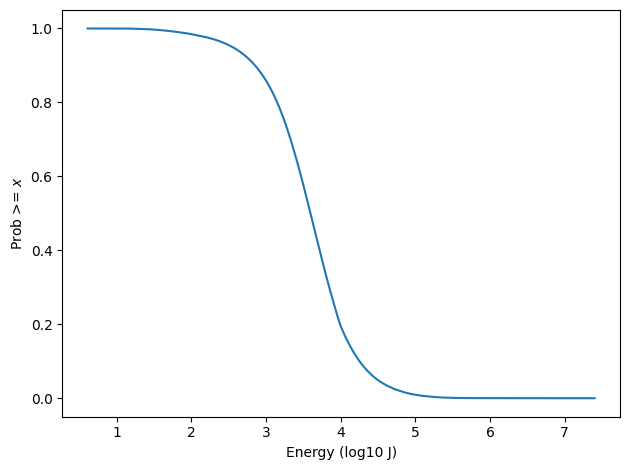

<IPython.core.display.Javascript object>

In [13]:
surv.plot()

decorate(xlabel=xlabel, ylabel=ylabel)

## Fit a Gaussian

Find the Gaussian that best matches percentiles with the data.

In [14]:
from empiricaldist import Pmf
from scipy.stats import norm


def truncated_normal_sf(qs, mu, sigma):
    ps = norm.sf(qs, mu, sigma)
    surv_model = Surv(ps / ps[0], qs)
    return surv_model

<IPython.core.display.Javascript object>

In [15]:
from scipy.optimize import least_squares


def fit_truncated_normal(surv):
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high, 1000)

    # match 20 percentiles from 1st to 99th
    ps = np.linspace(0.1, 0.99, 20)
    qs = surv.inverse(ps)

    def error_func(params):
        mu, sigma = params

        sf_model = truncated_normal_sf(qs_model, mu, sigma)
        error = surv(qs) - sf_model(qs)
        return error

    params = surv.mean(), surv.std()
    res = least_squares(error_func, x0=params, xtol=1e-3)
    assert res.success
    return res.x

<IPython.core.display.Javascript object>

In [16]:
mu, sigma = fit_truncated_normal(surv)
mu, sigma

(3.5827096529624645, 0.5119997112554249)

<IPython.core.display.Javascript object>

In [17]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, high, 2000)
surv_model = truncated_normal_sf(qs, mu, sigma)

<IPython.core.display.Javascript object>

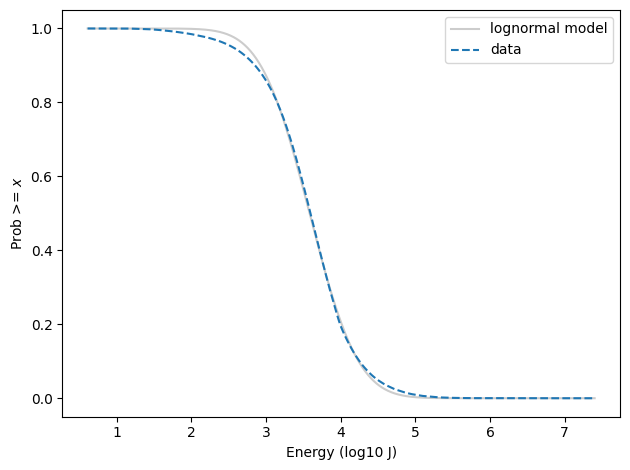

<IPython.core.display.Javascript object>

In [18]:
surv_model.plot(color="gray", alpha=0.4, label="lognormal model")
surv.plot(ls="--", label="data")

decorate(xlabel=xlabel, ylabel=ylabel)
plt.savefig("superbolt1.png", dpi=300)

Plot results with error bounds.

In [19]:
from scipy.stats import binom
from utils import underride


def empirical_error_bounds(surv, n, qs, alpha=0.95):
    """Find the bounds on a normal CDF analytically."""
    # find the correct probabilities
    ps = surv.make_cdf()(qs)

    # find the upper and lower percentiles of
    # a binomial distribution
    p_low = (1 - alpha) / 2
    p_high = 1 - p_low

    low = binom.ppf(p_low, n, ps) / n
    low[ps == 1] = 1
    high = binom.ppf(p_high, n, ps) / n
    return 1 - low, 1 - high

<IPython.core.display.Javascript object>

In [20]:
def plot_error_bounds(surv, n, **options):
    underride(options, linewidth=0, alpha=0.1, capstyle="round")
    qs = np.linspace(surv.qs.min(), surv.qs.max(), 100)
    low, high = empirical_error_bounds(surv, n, qs)

    plt.fill_between(qs, low, high, **options)

<IPython.core.display.Javascript object>

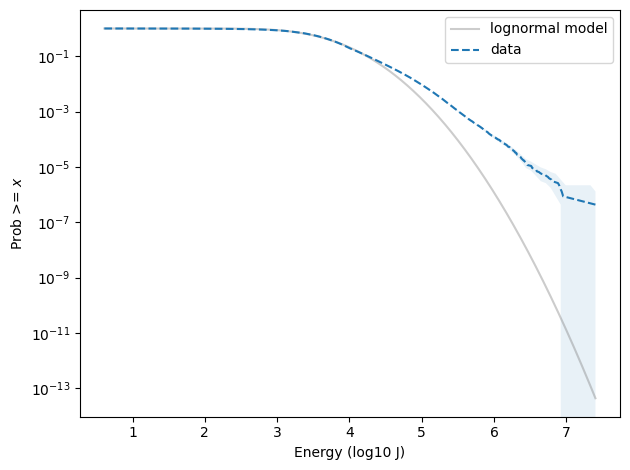

<IPython.core.display.Javascript object>

In [21]:
surv_model.plot(color="gray", alpha=0.4, label="lognormal model")
surv.plot(ls="--", label="data")

plot_error_bounds(surv, mags.count(), color="C0")

decorate(xlabel=xlabel, ylabel=ylabel, yscale="log")
plt.savefig("superbolt2.png", dpi=300)

The error bound extends to negative infinity, which means that at this sample size, it was plausible we would not have seen a stroke above magnitude 7.

Evaluating the empirical survival function and the model, we see that at magnitude 7, the model is off by about 4 orders of magnitude.

In [22]:
surv(7), surv_model(7)

(array(8.64939296e-07), array(1.29014571e-11))

<IPython.core.display.Javascript object>

## Fit a Student t

Find the df parameter that best matches the tail, then the mu and sigma parameters that best match the percentiles.

In [23]:
from scipy.stats import t as t_dist


def truncated_t_sf(qs, df, mu, sigma):
    ps = t_dist.sf(qs, df, mu, sigma)
    surv_model = Surv(ps / ps[0], qs)
    return surv_model

<IPython.core.display.Javascript object>

In [24]:
from scipy.optimize import least_squares


def fit_truncated_t(df, surv):
    """Given df, find the best values of mu and sigma."""
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high, 1000)

    # match 20 percentiles from 1st to 99th
    ps = np.linspace(0.01, 0.9, 20)
    qs = surv.inverse(ps)

    def error_func_t(params, df, surv):
        mu, sigma = params
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        error = surv(qs) - surv_model(qs)
        return error

    params = surv.mean(), surv.std()
    res = least_squares(error_func_t, x0=params, args=(df, surv), xtol=1e-3)
    assert res.success
    return res.x

<IPython.core.display.Javascript object>

In [25]:
from scipy.optimize import minimize


def minimize_df(df0, surv, bounds=[(1, 1e6)], ps=None):
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high * 1.0, 2000)

    if ps is None:
        t = surv.ps[0], surv.ps[-2]
        t = 0.1, surv.ps[-2]
        low, high = np.log10(t)
        ps = np.logspace(low, high, 30, endpoint=False)

    qs = surv.inverse(ps)

    def error_func_tail(params):
        (df,) = params
        mu, sigma = fit_truncated_t(df, surv)
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        errors = np.log10(surv(qs)) - np.log10(surv_model(qs))
        return np.sum(errors**2)

    params = (df0,)
    res = minimize(error_func_tail, x0=params, bounds=bounds, tol=1e-3, method="Powell")
    assert res.success
    return res.x

<IPython.core.display.Javascript object>

Search for the value of df that best matches the tail behavior.

In [26]:
df = minimize_df(5, surv, [(1, 1000)])
df

array([15.63237911])

<IPython.core.display.Javascript object>

Given that value of df, find mu and sigma to best match percentiles.

In [27]:
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([15.63237911]), 3.5820416456975206, 0.4941300882188064)

<IPython.core.display.Javascript object>

Run the model out to magnitude 8.

In [28]:
# low, high = surv.qs.min(), surv.qs.max()
low, high = surv.qs.min(), 8
qs = np.linspace(low, high, 2000)
surv_model = truncated_t_sf(qs, df, mu, sigma)

<IPython.core.display.Javascript object>

On a linear scale, the model looks pretty good.

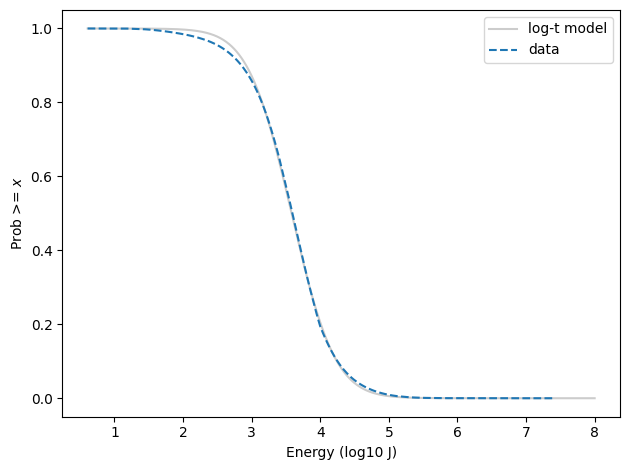

<IPython.core.display.Javascript object>

In [29]:
surv_model.plot(color="gray", alpha=0.4, label="log-t model")
surv.plot(ls="--", label="data")

decorate(xlabel=xlabel, ylabel=ylabel)
plt.savefig("superbolt3.png", dpi=300)

On a log scale we can see that it matches the tail behavior much better than the Gaussian model.

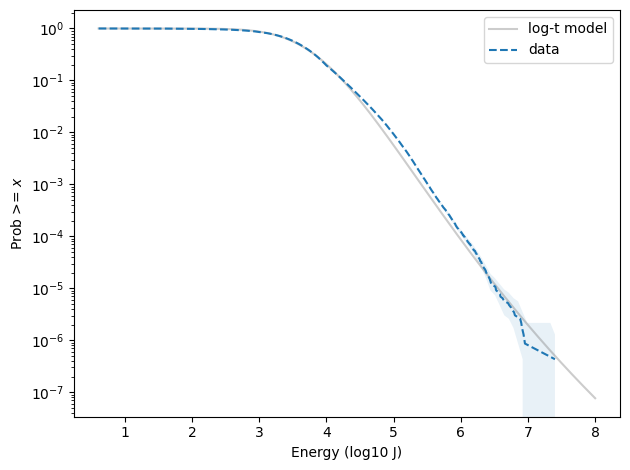

<IPython.core.display.Javascript object>

In [30]:
surv_model.plot(color="gray", alpha=0.4, label="log-t model")
surv.plot(ls="--", label="data")

plot_error_bounds(surv, mags.count(), color="C0")

decorate(xlabel=xlabel, ylabel=ylabel, yscale="log")
plt.savefig("superbolt4.png", dpi=300)


## Now with all the data!

Read the binned data from Figure 2 of ["Global Distribution of Superbolts"](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019JD030975).

In [31]:
binned = pd.read_csv("SB2019rawCounts.txt", sep="\t", header=None)
binned

,0,1,2
0,10.00,1.113000e+01,949197
1,11.13,1.240000e+01,599878
2,12.40,1.380000e+01,705316
3,13.80,1.537000e+01,818835
4,15.37,1.711000e+01,955340
...,...,...,...
145,58434141.34,6.506289e+07,4
146,65062887.49,7.244360e+07,3
147,72443596.01,8.066157e+07,0
148,80661569.22,8.981179e+07,1


<IPython.core.display.Javascript object>

Place each point in the logarithmic center of its bin.

In [32]:
log_center = (np.log10(binned[0]) + np.log10(binned[1])) / 2
log_center.describe()

count    150.000000
mean       4.499997
std        2.027455
min        1.023248
25%        2.761667
50%        4.500000
75%        6.238333
max        7.976667
dtype: float64

<IPython.core.display.Javascript object>

Make a PMF.

In [33]:
ps = binned[2].values
pmf2 = Pmf(ps, index=log_center)
pmf2.sum()

1077038042

<IPython.core.display.Javascript object>

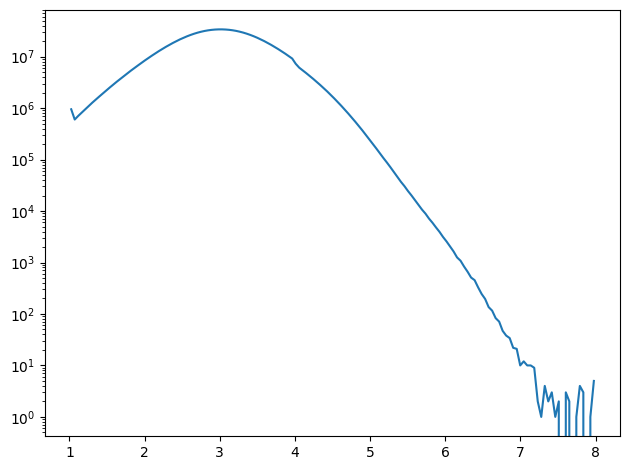

<IPython.core.display.Javascript object>

In [34]:
pmf2.plot()
decorate(yscale="log")

Make a tail distribution (a nonstandard survival curve that represents the probability >= each value of x, rather than strictly greater).

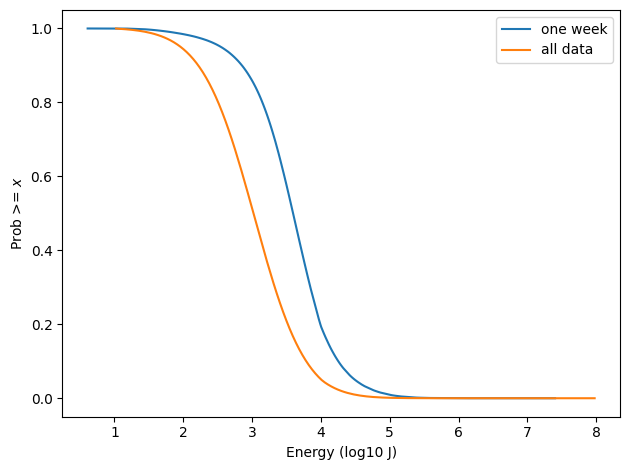

<IPython.core.display.Javascript object>

In [35]:
pmf2.normalize()
surv2 = Surv(pmf2.make_surv() + pmf2)
surv2.iloc[0]

surv.plot(label="one week")
surv2.plot(label="all data")

decorate(xlabel=xlabel, ylabel=ylabel)

### Gaussian model

In [36]:
mu, sigma = fit_truncated_normal(surv2)
mu, sigma

(3.0127965419077416, 0.6048350889257574)

<IPython.core.display.Javascript object>

In [37]:
low, high = surv2.qs.min(), surv2.qs.max()
qs = np.linspace(low, high, 2000)
surv_model2 = truncated_normal_sf(qs, mu, sigma)

<IPython.core.display.Javascript object>

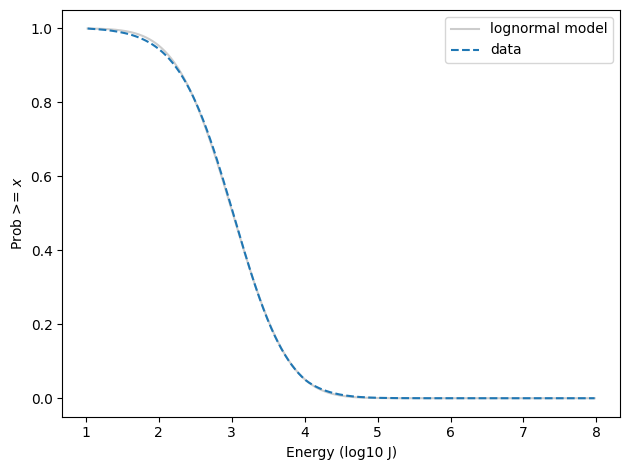

<IPython.core.display.Javascript object>

In [38]:
surv_model2.plot(color="gray", alpha=0.4, label="lognormal model")
surv2.plot(ls="--", label="data")

decorate(xlabel=xlabel, ylabel=ylabel)
plt.savefig("superbolt5.png", dpi=300)

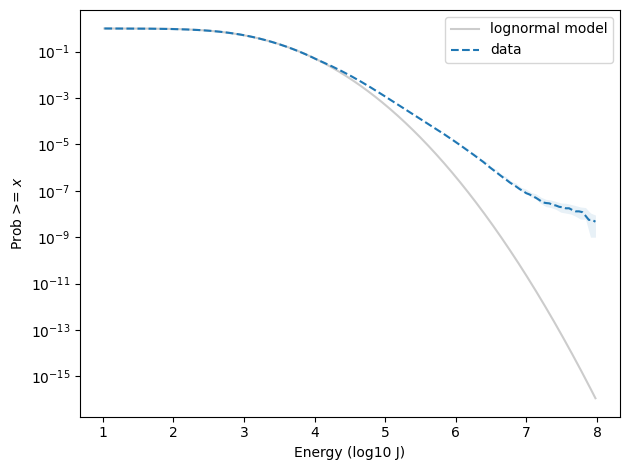

<IPython.core.display.Javascript object>

In [39]:
surv_model2.plot(color="gray", alpha=0.4, label="lognormal model")
surv2.plot(ls="--", label="data")

# calculate error bounds based on a sample size of 1 billion
plot_error_bounds(surv2, 1e9, color="C0")

decorate(xlabel=xlabel, ylabel=ylabel, yscale="log")
plt.savefig("superbolt6.png", dpi=300)

In [40]:
surv2(7.9), surv_model2(7.9)

(array(5.57083391e-09), array(3.3836566e-16))

<IPython.core.display.Javascript object>

### Student t model

In [41]:
df = minimize_df(5, surv2, [(1, 1000)])
df

array([28.49482247])

<IPython.core.display.Javascript object>

In [42]:
mu, sigma = fit_truncated_t(df, surv2)
df, mu, sigma

(array([28.49482247]), 3.0120077516499237, 0.5934553421116102)

<IPython.core.display.Javascript object>

In [43]:
low, high = surv2.qs.min(), surv2.qs.max()
# low, high = surv2.qs.min(), 8
qs = np.linspace(low, high, 2000)
surv_model2 = truncated_t_sf(qs, df, mu, sigma)

<IPython.core.display.Javascript object>

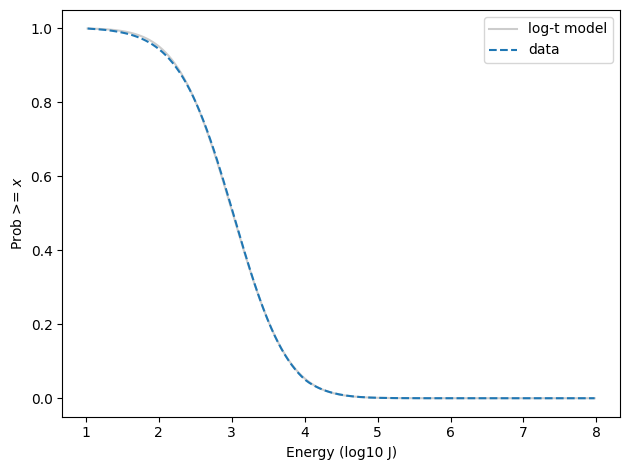

<IPython.core.display.Javascript object>

In [44]:
surv_model2.plot(color="gray", alpha=0.4, label="log-t model")
surv2.plot(ls="--", label="data")

decorate(xlabel=xlabel, ylabel=ylabel)
plt.savefig("superbolt7.png", dpi=300)

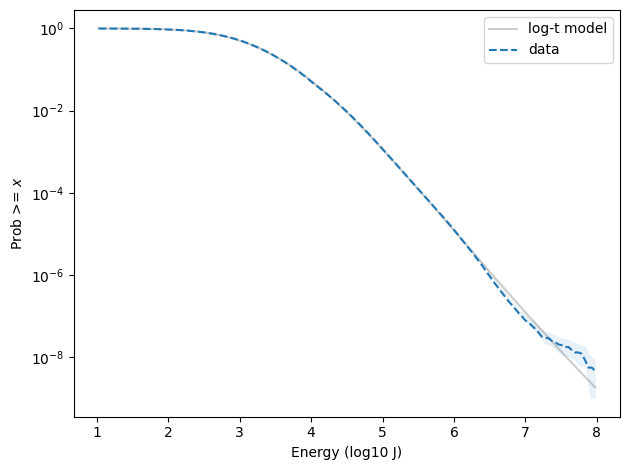

<IPython.core.display.Javascript object>

In [45]:
surv_model2.plot(color="gray", alpha=0.4, label="log-t model")
surv2.plot(ls="--", label="data")

# calculate error bounds based on a sample size of 1 billion
plot_error_bounds(surv2, 1e9, color="C0")

decorate(xlabel=xlabel, ylabel=ylabel, yscale="log")
plt.savefig("superbolt8.png", dpi=300)